# Preamble

## Imports

In [1]:
%matplotlib inline
import networkx as nx
import community
import numpy as np
import matplotlib.pylab as plt
import sys
from collections import Counter, defaultdict
from random import choice
from sklearn.metrics.cluster import normalized_mutual_info_score, mutual_info_score
import subprocess
import re
import itertools
import scipy
import random
from random import choice
from ulf import ulf
from functools import wraps
from multiprocessing import Process, Queue, Pool
from scipy.stats import beta
import time

import numpy as np, scipy.stats as st

## Set layout params

In [835]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

## Visualization functions

In [3]:
def draw(G, partition="teal"):
    if partition == True:
        partition = community.best_partition(G).values()
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos=pos, node_size=50, alpha=1.0, linewidths=0, node_color=partition)
    nx.draw_networkx_edges(G, pos=pos, width=1, alpha=.3)
    plt.axis("off")
    
def scatter_mean(X, Y, c, label=""):
    plt.plot(
        np.mean(np.array(X), axis=0),
        np.mean(np.array(Y), axis=0),
        c=c, lw=2, ls="--", label=label
    )
    
def confidence_intervals(X, Y, c, label="", mid_50_percentile=False, lw=2):
    X, Y = np.array(X), np.array(Y)
    low, upp = st.t.interval(
        0.99,
        Y.shape[0]-1,
        loc=np.mean(Y, axis=0),
        scale=st.sem(Y)
    )
    plt.fill_between(
        np.mean(X, axis=0),
        low,
        upp,
        alpha=0.5,
        color=c,
        lw=0
    )
    plt.plot(
        np.mean(X, axis=0),
        np.mean(Y, axis=0),
        lw=lw,
        c=c,
        label=label
    )
    if mid_50_percentile:
        plt.fill_between(
            np.mean(X, axis=0),
            np.percentile(Y, 25, axis=0),
            np.percentile(Y, 75, axis=0),
            alpha=.25,
            color=c
        )

## Analysis functions

In [4]:
def NMI_score(p1, p2):
    nodes = sorted(set(p1.keys()) & set(p2.keys()))
    return normalized_mutual_info_score(
        [p1[n] for n in nodes],
        [p2[n] for n in nodes]
    )

def interlayer_NMI(layer_commu, signal_layers):
    """Return signal-noise NMI and noise-noise NMI"""
    layers = sorted(layer_commu.keys())
    partitions = defaultdict(dict)
    for l in layers:
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                partitions[l][int(n)] = c

    similarity = np.zeros((len(layers), len(layers)))
    for l1 in layers:
        partition1 = partitions[l1]
        for l2 in layers:
            partition2 = partitions[l2]
            try:
                similarity[l1, l2] = NMI_score(partition1, partition2)
            except:
                globals().update(locals())
                similarity[l1, l2] = NMI_score(partition1, partition2)
    
    signal_layers = set(signal_layers)
    noise_layers = set(layers) - signal_layers
    
    signal_signal_NMI = np.mean([
        np.mean(similarity[sl, list(signal_layers - {sl})])
        for sl in signal_layers
    ])
    
    signal_noise_mean_NMI = np.mean([
        np.mean(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    signal_noise_std_NMI = np.mean([
        np.std(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    noise_noise_NMI = np.mean([
        np.mean(similarity[nl, list(noise_layers - {nl})])
        for nl in noise_layers
    ])
    
    return signal_signal_NMI, signal_noise_mean_NMI, signal_noise_std_NMI, noise_noise_NMI

    

def independent_edge_swaps(G, num_swaps):
    Gc = G.copy()
    for _ in range(num_swaps):
        nx.double_edge_swap(Gc, 1)
    return Gc

def Infomap(pajek_string, *args):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        with open('input/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), n.split('"')[1])
            for n in re.split(r"\*.+", parsed_network)[1].split("\n")[1:-1]
        )
    
    def _parse_communities_multiplex(id_to_label, filename):
        with open('output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu = [tuple(i.split()) for i in la_no_clu]

        communities_json = defaultdict(set)
        for layer, node, cluster, _ in la_no_clu:
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json  # {layer: {(node, cluster), ...}, ...}
    
    def _parse_communities_planar(id_to_label, filename):
        with open('output/'+filename+".clu", 'r') as infile:
            clusters = infile.read()
        
        # Get nodes and clusters from .clu file
        no_clu = [tuple(i.split()[:-1]) for i in re.findall(r"\d+ \d+ \d\.\d+", clusters)]  # [(node, cluster), ...]
        return {0: set([(id_to_label[int(no)], int(clu)) for no, clu in no_clu])}
    
    def _clean_up(filename):
        subprocess.call(['rm', 'input/'+filename+'.net'])
        subprocess.call(['rm', 'output/'+filename+'_expanded.clu'])
        subprocess.call(['rm', 'output/'+filename+'.clu'])
    
    # Check for process id in args (for multiprocessing)
    if args[-1][:3] == "pid":
        pid = args[-1][3:]
        args = args[:-1]
    else:
        pid = ""
        
    # Get network in multiplex string format and define filename
    filename = 'tmpnet' + pid

    # Store locally
    with open("input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    
    if 'multiplex' in list(args):
        parsed_communities = _parse_communities_multiplex(id_to_label, filename)
    if 'pajek' in list(args):
        parsed_communities = _parse_communities_planar(id_to_label, filename)
        
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu-1].append(no)
            except KeyError:
                communities[clu-1] = [no]
        layer_communities[layer] = communities

    return communities, layer_communities

# Analysis

## Generate networks

In [5]:
def temporal_network_with_signal_layer(G_signal, N_signal, N_noise, num_swaps=100):
    """Build temporal network with noise around a signal layer.
    
    Input
    -----
    G_signal : networkx.classes.graph.Graph
    N_signal : int
    N_noise : int
    num_swaps : int
    
    Output
    ------
    out : str
        Temporal network in pajek format
    """
    
    def write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    def _independent_edge_swaps(G, num_swaps):
        Gc = G.copy()
        for _ in range(num_swaps):
            nx.double_edge_swap(Gc, 1)
        return Gc
    
    # Layer numbers in a vector
    layers = range(N_signal + N_noise)
    
    # Pick the position of the signal layers
    signal_layers = []
    for _ in range(N_signal):
        signal_layers.append(choice(list(set(layers) - set(signal_layers))))
    
    # Create layer-edge map
    layer_edges = dict(
        (l, G_signal.edges()) if l in signal_layers else
        (l, _independent_edge_swaps(G_signal.copy(), num_swaps).edges())
        for l in layers
    )
    
    return write_pajek(_create_adjacency_matrix(layer_edges)), signal_layers



def gen_G(network_size=100, K=3, P=1, cut_nodes=15):
    G = nx.powerlaw_cluster_graph(network_size + cut_nodes, K, P)
    for n, k in sorted(G.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
        G.remove_node(n)
    for n, k in G.degree().items():
        if k == 0: G.remove_node(n)
    return G

## Simulate NMI between planted signal layers and noise layers

In [6]:
def simulate_NMI_vs_num_swaps(N_signal, N_noise, reps=10):
    """Compute NMI vs number of swaps in noise layers
    
    1. Create a signal layer, with a predefined structure, and embed that into a
    temporal network in at N_signal different times.
    2. Copy the signal layer and 
    permute it by num_swaps edge swaps and insert that at N_noise different times.
    3. Record the average NMI between the signal layers and the noise layers.
    4. Record the average NMI between the noise layers.
    5. Repeat 1-4 for increasing num_swaps.
    """
    X = []
    Y0ss, Y0snM, Y0snSD, Y0nn = [], [], [], []
    Y1ss, Y1snM, Y1snSD, Y1nn = [], [], [], []
    Y2ss, Y2snM, Y2snSD, Y2nn = [], [], [], []
    try:
        for _ in range(reps):

            G = gen_G()

            x = []
            y0ss, y0snM, y0snSD, y0nn = [], [], [], []
            y1ss, y1snM, y1snSD, y1nn = [], [], [], []
            y2ss, y2snM, y2snSD, y2nn = [], [], [], []
            
            for num_swaps in sorted(set([int(num_swaps) for num_swaps in np.logspace(0.1, np.log10(500), 25, base=10)])):

                temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

                _, layer_commu_pred_1 = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--multiplex-relax-limit', '1',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )
                
                _, layer_commu_pred_all = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                _, layer_commu_pred_js = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                y0ss_, y0snM_, y0snSD_, y0nn_ = interlayer_NMI(layer_commu_pred_1, signal_layers)
                y1ss_, y1snM_, y1snSD_, y1nn_ = interlayer_NMI(layer_commu_pred_all, signal_layers)
                y2ss_, y2snM_, y2snSD_, y2nn_ = interlayer_NMI(layer_commu_pred_js, signal_layers)
                
                x.append(num_swaps)            
                y0ss.append(y0ss_)
                y0snM.append(y0snM_)
                y0snSD.append(y0snSD_)
                y0nn.append(y0nn_)
                y1ss.append(y1ss_)
                y1snM.append(y1snM_)
                y1snSD.append(y1snSD_)
                y1nn.append(y1nn_)
                y2ss.append(y2ss_)
                y2snM.append(y2snM_)
                y2snSD.append(y2snSD_)
                y2nn.append(y2nn_)

                print num_swaps,
            print

            X.append(x)
            Y0ss.append(y0ss)
            Y0snM.append(y0snM)
            Y0snSD.append(y0snSD)
            Y0nn.append(y0nn)
            Y1ss.append(y1ss)
            Y1snM.append(y1snM)
            Y1snSD.append(y1snSD)
            Y1nn.append(y1nn)
            Y2ss.append(y2ss)
            Y2snM.append(y2snM)
            Y2snSD.append(y2snSD)
            Y2nn.append(y2nn)

        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
    except KeyboardInterrupt:
        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
def simulate_NMI_vs_N_noise(N_signal, num_swaps=500, reps=10):
    """Compute NMI vs number of swaps in noise layers
    
    1. Create a signal layer, with a predefined structure, and embed that into a
    temporal network in at N_signal different times.
    2. Copy the signal layer and 
    permute it by num_swaps edge swaps and insert that at N_noise different times.
    3. Record the average NMI between the signal layers and the noise layers.
    4. Record the average NMI between the noise layers.
    5. Repeat 1-4 for increasing num_swaps.
    """
    
    X = []
    Y0ss, Y0snM, Y0snSD, Y0nn = [], [], [], []
    Y1ss, Y1snM, Y1snSD, Y1nn = [], [], [], []
    Y2ss, Y2snM, Y2snSD, Y2nn = [], [], [], []
    
    try:
        for _ in range(reps):

            G = gen_G()

            x = []
            y0ss, y0snM, y0snSD, y0nn = [], [], [], []
            y1ss, y1snM, y1snSD, y1nn = [], [], [], []
            y2ss, y2snM, y2snSD, y2nn = [], [], [], []
            
            for N_noise in map(int, np.linspace(5, 100, 20)):

                temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

                _, layer_commu_pred_1 = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--multiplex-relax-limit', '1',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )
                
                _, layer_commu_pred_all = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                _, layer_commu_pred_js = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                y0ss_, y0snM_, y0snSD_, y0nn_ = interlayer_NMI(layer_commu_pred_1, signal_layers)
                y1ss_, y1snM_, y1snSD_, y1nn_ = interlayer_NMI(layer_commu_pred_all, signal_layers)
                y2ss_, y2snM_, y2snSD_, y2nn_ = interlayer_NMI(layer_commu_pred_js, signal_layers)
                
                x.append(N_noise)            
                y0ss.append(y0ss_)
                y0snM.append(y0snM_)
                y0snSD.append(y0snSD_)
                y0nn.append(y0nn_)
                y1ss.append(y1ss_)
                y1snM.append(y1snM_)
                y1snSD.append(y1snSD_)
                y1nn.append(y1nn_)
                y2ss.append(y2ss_)
                y2snM.append(y2snM_)
                y2snSD.append(y2snSD_)
                y2nn.append(y2nn_)


                print N_noise,
            print

            X.append(x)
            Y0ss.append(y0ss)
            Y0snM.append(y0snM)
            Y0snSD.append(y0snSD)
            Y0nn.append(y0nn)
            Y1ss.append(y1ss)
            Y1snM.append(y1snM)
            Y1snSD.append(y1snSD)
            Y1nn.append(y1nn)
            Y2ss.append(y2ss)
            Y2snM.append(y2snM)
            Y2snSD.append(y2snSD)
            Y2nn.append(y2nn)

        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
    except KeyboardInterrupt:
        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
#X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn = simulate_NMI_vs_num_swaps(2, 10, reps=100)
X1, Y0ss1, Y0snM1, Y0snSD1, Y0nn1, Y1ss1, Y1snM1, Y1snSD1, Y1nn1, Y2ss1, Y2snM1, Y2snSD1, Y2nn1 = simulate_NMI_vs_N_noise(2, 500, reps=100)

5 10


### NMI of signal layers with noise layers

####  As function of increasing noisyness

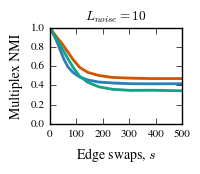

In [837]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals(X, Y0snM, "#2980b9", label="Adjacent layers linked")
confidence_intervals(X, Y1snM, c="#d35400", label="All layers linked")
confidence_intervals(X, Y2snM, c="#16a085", label="Divergence prop. links")
#confidence_intervals(X, Ynn, c="#2c3e50", label="Random")
#scatter_mean(X, Ynn, c="#2c3e50", label="Baseline")

# Y2nn_last = np.array(Y2nn)[:, -1]
# plt.plot(X[0], [np.mean(Y2nn_last)] * (len(X[0])), c="#2c3e50", ls="--", lw=2.5, label="Baseline (random)")
# # low, upp = st.t.interval(0.99, Y2nn_last.shape[0]-1, loc=np.mean(Y2nn_last), scale=st.sem(Y2nn_last))
# # plt.fill_between(X[0], low, upp, color="k", alpha=0.5)

#plt.xticks(fontsize=12)
#plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.title("$L_{noise} = 10$")
plt.xlabel("Edge swaps, $s$")
plt.ylabel("Multiplex NMI")

plt.ylim(0.0, 1.0)
plt.xlim(0.0, 500)
plt.savefig("figures/NMI_vs_num_edgeswaps.pdf")
plt.show()

#### As function of increasing number of noise layers

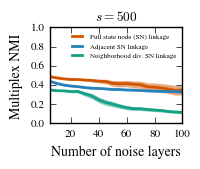

In [841]:
plt.figure(None, figsize=(3.42/2.0, 1.2), frameon=False)

confidence_intervals(X1, Y1snM1, c="#d35400", label="Full state node (SN) linkage")
confidence_intervals(X1, Y0snM1, "#2980b9", label="Adjacent SN linkage")
confidence_intervals(X1, Y2snM1, c="#16a085", label="Neighborhood div. SN linkage")
#scatter_mean(X1, Y2nn1, "#2c3e50", label="Baseline")

#plt.xticks(fontsize=12)
#plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.title("$s=500$")
plt.xlabel("Number of noise layers")
plt.ylabel("Multiplex NMI")

plt.ylim(0.0, 1.0)
plt.xlim(5.0, 100)
plt.legend(loc="upper right", fontsize=5, frameon=False)
plt.savefig("figures/NMI_vs_N_noise.pdf")
plt.show()

## Simulate NMI between noise layers for increasing number of edge swaps

In [ ]:
N_signal, N_noise = 1, 10

G = gen_G()

Ynn = []
for _ in range(100):
    x = []
    ynn = []

    for num_swaps in sorted(set([int(num_swaps) for num_swaps in np.logspace(0.1, np.log10(500), 25, base=10)])):

        temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

        _, layer_commu_pred_js = Infomap(
            temporal_network,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        noise_layers = list(set(range(N_signal+N_noise)) - set(signal_layers))
        ynn.append(np.mean([
             normalized_mutual_info_score(
                np.random.randint(len(layer_commu_pred_js[l1]), size=len(G.nodes())),
                np.random.randint(len(layer_commu_pred_js[l2]), size=len(G.nodes()))
            )
            for l1 in noise_layers
            for l2 in noise_layers
            if l2 > l1
        ]))
        x.append(num_swaps)

        print num_swaps, 
        
    Ynn.append(ynn)

1 2 3 4 5 7 9 11 15 19 25 32 41 53 68 87 112 143 184 236 303 389 499 1 2 3 4 5 7 9 11 15 19 25 

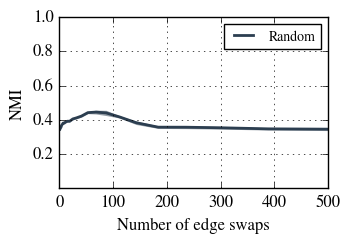

In [805]:
plt.figure(None, frameon=False)

confidence_intervals(X, Ynn, c="#2c3e50", label="Random")

plt.xticks(fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Number of edge swaps", fontsize=12)
plt.ylabel("NMI", fontsize=12)

plt.ylim(0.0, 1.0)
plt.grid()
plt.legend()
#plt.savefig()
plt.show()

## Non-overlapping caveman communities

In [6]:
def temporal_caveman_network_non_overlap(num_signal, noise_spacing, l=10, k=5, num_swaps=0):
    """Build temporal network caveman signal layers and random clustered noise space layers.
    
    NB: If l and k are used with other values than default update the noise layer!
    
    Input
    -----
    num_signal : int
    noise_spacing : int
    l : int (number of cliques in a signal layer)
    k : int (number of members in each caveman clique)
    num_swaps : int (number of noise swaps inside signal layers)
    
    Output
    ------
    out : str
        Temporal network in pajek format
    """
    
    def write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    def edge_swaps(G, num_swaps):
        """Non-inline edge swapping."""
        Gc = G.copy()
        return nx.double_edge_swap(Gc, num_swaps, max_tries=10000)
    
    def get_random_graph():
        """Warning! Scientist coding. This is only valid is default params for l and k are used!"""
        return nx.random_partition_graph([2, 3, 5, 6, 7, 8, 9, 10], 0.4, 0.05)
    
    G = nx.caveman_graph(l, k)
    partition = community.best_partition(G)
    G = nx.double_edge_swap(G, num_swaps)
    
    layers = range(num_signal * (noise_spacing + 1))
    signal_layers = [l for l in layers if l % (noise_spacing + 1) == 0]
    
    # Layer-edge map  # {layer: [(node, node), (node, node), ...], ...}
    layer_edges = dict(
        (l, G.edges()) if l in signal_layers else
        (l, get_random_graph().edges())
        for l in layers
    )
    
    return write_pajek(_create_adjacency_matrix(layer_edges)), partition, signal_layers

### NMI between recovered and planted a.f.o. number of noise spacing

In [7]:
def multiplex_to_planar(multilayer_network=None):
    
    if multilayer_network is None:
        # Get internal representation of multilayer network from cache
        with open('output/tmpnet.net', 'r') as fp:
            multilayer_network = fp.read()

    # Unwrap nodes and edges
    nodes = set()
    edges = []
    for edge_str in re.split(r"\*.+", multilayer_network)[2].split("\n"):
        
        if len(edge_str) == 0 or edge_str[0] == "#":
            continue

        if edge_str == '':
            print "Fuck!"; break

        if len(edge_str.split()) == 5:
            l1, n1, l2, n2, w = edge_str.split()
        if len(edge_str.split()) == 4:
            l1, n1, n2, w = edge_str.split()
            l2 = l1
            if n1 == "node":
                print n1

        l1n1 = l1 + "_" + n1
        l2n2 = l2 + "_" + n2

        nodes.update([l1n1, l2n2])
        edges.append((l1n1, l2n2, w))

    # Stitch back together as planar network
    name_to_id_map = zip(nodes, range(len(nodes)))
    name_to_id_dict = dict(name_to_id_map)

    planar_network = "*Vertices %d" % len(nodes)
    for node, ni in name_to_id_map:
        planar_network += '\n%d "%s" 1.0' % (ni, node)

    planar_network += "\n*Edges %d" % len(edges)
    for edge in edges:
        planar_network += "\n%d %d %s" % (name_to_id_dict[edge[0]], name_to_id_dict[edge[1]], edge[2])

    return planar_network

def planer_layer_commu_to_multiplex(layer_commu):
    layer_commu = layer_commu[0]
    layer_commu_out = defaultdict(lambda: defaultdict(list))
    for c, state_nodes in layer_commu.items():
        for la_no in state_nodes:
            la, no = map(int, la_no.split("_"))
            layer_commu_out[la][c].append(no)
    return layer_commu_out

def avg_NMI_with_signal_layers(layer_commu, signal_layers, partition_true):
    def _NMI_score(p1, p2):
        nodes = sorted(set(p1.keys()) & set(p2.keys()))
        return normalized_mutual_info_score(
            [p1[n] for n in nodes],
            [p2[n] for n in nodes]
        )
    scores = []
    for l in signal_layers:
        partition_pred_l = defaultdict(int)
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                partition_pred_l[int(n)] = int(c)
        scores.append(_NMI_score(partition_pred_l, partition_true))
    return np.mean(scores)

for noise_spacing in range(0, 2):
    temporal_network, partition_true, signal_layers = temporal_caveman_network_non_overlap(10, noise_spacing)

    _, _ = Infomap(
        temporal_network,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--multiplex-relax-limit', '1',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z',
        '--no-infomap'
    )
    
    temporal_network = multiplex_to_planar()
    
    _, layer_commu_pred_1 = Infomap(
        temporal_network,
        'output/',
        '-i',
        'pajek',
        '--overlapping',
        '--clu',
        '--two-level',
        '-z',
    )

    _, layer_commu_pred_all = Infomap(
        temporal_network,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-relax-rate', '0.25',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z',
        '--no-infomap'
    )

    _, layer_commu_pred_js = Infomap(
        temporal_network,
        'output/',
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', '0.5',
        '--overlapping',
        '--expanded',
        '--clu',
        '--pajek',
        '--two-level',
        '-z',
        '--no-infomap'
    )
    
    print noise_spacing
    print avg_NMI_with_signal_layers(layer_commu_pred_1, signal_layers, partition_true)
    print avg_NMI_with_signal_layers(layer_commu_pred_all, signal_layers, partition_true)
    print avg_NMI_with_signal_layers(layer_commu_pred_js, signal_layers, partition_true)
    print

IOError: [Errno 2] No such file or directory: 'output/tmpnet_expanded.clu'

In [362]:
def graph_list_to_pajek(G_list):
    """Convert list of graphs to multilayer pajek string
    
    Input
    -----
    G_list : list
        Networkx graphs
    
    Output
    ------
    out : str
        Pajek filestring in *Intra format
    """
    def _write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    return _write_pajek(
        _create_adjacency_matrix(
            dict(zip(range(len(G_list)), [G.edges() for G in G_list]))
        )
    )

def invert_partition(partition):
    if type(partition.items()[0][1]) is list:
        partition_inv = dict()
        for c, nodes in partition.items():
            for n in nodes:
                partition_inv[n] = c
    else:
        partition_inv = defaultdict(list)
        for n, c in partition.items():
            partition_inv[c].append(n)
    return ulf.default_to_regular(partition_inv)

def create_planted_partition_graph(l, k, p_in, p_out):
    def _get_shuffle_mapping(G):
        nodes = G.nodes()[:]
        nodes_shuf = G.nodes()[:]; random.shuffle(nodes_shuf)
        return dict(zip(nodes, nodes_shuf))
    G = nx.planted_partition_graph(l, k, p_in, p_out)
    G = nx.relabel_nodes(G, _get_shuffle_mapping(G))
    partition = community.best_partition(G)
    return G, partition

def multilayer_network_with_L_samples(G_arr, L):
    def sample_from_graph(G, p):
        G_sample = nx.Graph()
        G_sample.add_nodes_from(G.nodes())
        G_sample.add_edges_from(random.sample(G.edges(), int(p*len(G.edges()))))
        return G_sample
    G_arr_sampled = []
    for G in G_arr:
        for _ in range(L):
            G_arr_sampled.append(sample_from_graph(G, 1.0/L))
    return graph_list_to_pajek(G_arr_sampled)

def multilayer_network_with_L_samples_non_iid(G_arr, L):
    if L == 1:
        return graph_list_to_pajek(G_arr)
    else:
        G_arr_sampled = []
        for G in G_arr:
            edges = set(G.edges())
            for _ in range(L):
                edges_s = random.sample(edges, int(1.0/L * len(G.edges())))
                edges = edges - set(edges_s)
                Gs = nx.Graph()
                Gs.add_edges_from(edges_s)
                G_arr_sampled.append(Gs)
        return graph_list_to_pajek(G_arr_sampled)

def LFR_benchmark_graph(mu=0.05):
#     mu_b, sigma2_b = 0.160, 0.025
#     a = mu_b * (mu_b * (1 - mu_b) / sigma2_b - 1)
#     b = a * (1 - mu_b) / mu_b
    degree_dist = map(int, np.random.beta(5, 5, 128) * 31 + 1)

    nodes = range(128)
    random.shuffle(nodes)
    commu_nodes = dict((c, nodes[c*32:(c+1)*32]) for c in range(4))
    node_commu = invert_partition(commu_nodes)
    
    degree_sequence = dict(zip(nodes, degree_dist))

    G = nx.MultiGraph()
    G.add_nodes_from(nodes)

    for ni, n in enumerate(sorted(nodes, key=lambda n: degree_sequence[n], reverse=True)):
        num_free_edges = degree_sequence[n] - G.degree(n)
        for e in range(num_free_edges):
            possible_nodes = [pn for pn, d in G.degree().items() if d < degree_sequence[pn] and pn != n]# and pn not in G.neighbors(n)]
            possible_nodes = sorted(possible_nodes, key=lambda pn: degree_sequence[pn] - G.degree(pn), reverse=True)
            if np.random.choice(["intra", "inter"], p=[1-mu, mu]) == "intra":
                try_nodes = [_n for _n in possible_nodes if _n in commu_nodes[node_commu[n]]]
            else:
                try_nodes = [_n for _n in possible_nodes if not _n in commu_nodes[node_commu[n]]]

            if len(try_nodes) == 0:
                quality = (np.mean(G.degree().values()) - np.mean(degree_sequence.values()))
                if quality < -1:
                    #print "diff(embedded, true) average degree is %.02f, trying again" % quality
                    LFR_benchmark_graph(mu=mu)
                else:
                    pass
                    #print "diff(embedded, true) average degree is %.02f" % quality
                return G, node_commu
            cn = random.choice(try_nodes)
            G.add_edge(n, cn)
    return G, node_commu

def multigraph_to_weighted_graph(M):
    G = nx.Graph()
    for u, v, data in M.edges_iter(data=True):
        w = data['weight'] if 'weight' in data else 1.0
        if G.has_edge(u,v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)
    return G

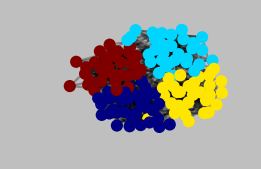

In [103]:
G, p = LFR_benchmark_graph(mu=0.1)
ulf.draw(multigraph_to_weighted_graph(G), partition=zip(*sorted(p.items(), key=lambda (k, v): k))[1])

In [762]:
def mean_sample_NMI(layer_commu, G_arr, L, partitions):
    return np.mean([
        NMI_score(
            dict((int(n), c) for n, c in invert_partition(layer_commu[i*L + l]).items()),
            partitions[i]
        )
        for i, _ in enumerate(G_arr)
        for l in range(L)
    ])
    
def worker(args):
    _, _layer_commu = Infomap(
        *args
    )
    return _layer_commu, args[-1][3:]

def NMI_vs_L(G_arr, partitions, L_max):
    NMI_js50, NMI_full15, NMI_adj15, NMI_single = [], [], [], []
    L_arr = range(1, L_max+1)
    
    data = []
    
    for L in L_arr:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        
        args = [
            pajek_synth,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs50_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidfull15_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.15',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidadj15_L%d' % L
        ]
        
        data.append(args)

        args = [
            pajek_synth,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-relax-rate', '0.0',
            '--multiplex-relax-limit', '1'
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidsingle_L%d' % L
        ]
        
        data.append(args)
    
    p = Pool(8)
    processes = p.map(worker, data)
    
    for output in processes:
        layer_commu, pid = output
        algo = pid.split("_")[0]
        L = int(pid.split("L")[1])
        locals()['NMI_%s' % algo].append(mean_sample_NMI(layer_commu, G_arr, L, partitions))
        
    p.close()
    
    return NMI_js50, NMI_full15, NMI_adj15, NMI_single


def run_simulation(T, n_iter, *args):
    
    if args == ():
        js50, full15, adj15, single = [], [], [], []
    else:
        js50, full15, adj15, single = args
        
    for i in range(n_iter):
        G_arr, partitions = map(
            list,
            zip(*[LFR_benchmark_graph(mu=0.05) for _ in range(T)])
        )
        NMI_js50, NMI_full15, NMI_adj15, NMI_single = NMI_vs_L(G_arr, partitions, 12)
        js50.append(NMI_js50)
        full15.append(NMI_full15)
        adj15.append(NMI_adj15)
        single.append(NMI_single)
        print i,
        time.sleep(5)
        
    return js50, full15, adj15, single

jsT1, fullT1, adjT1, singleT1 = run_simulation(1, 50)
#jsT3, fullT3, adjT3, singleT3 = run_simulation(3, 100)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49


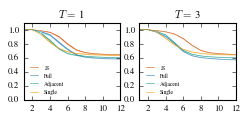

In [259]:
def make121(X):
    return np.append(np.ones((np.array(X)[:, 2:].shape[0], 2)), np.array(X)[:, 2:], axis=1)
    
plt.figure(None, figsize=(3.42, 1.2), frameon=False)
for fignum, T in enumerate([1, 3], 1):

    L_max = 12
    X = [range(1, L_max+1)]

    plt.subplot(1, 2, fignum)
    plt.title("$T =$ %d" % T)
    confidence_intervals(X, make121(globals()["jsT%d" % T]), c="#d35400", label="JS", lw=0.5)
    confidence_intervals(X, make121(globals()["fullT%d" % T]), "#2980b9", label="Full", lw=0.5)
    confidence_intervals(X, make121(globals()["adjT%d" % T]), c="#16a085", label="Adjacent", lw=0.5)
    confidence_intervals(X, make121(globals()["singleT%d" % T]), c="#f39c12", label="Single", lw=0.5)

    plt.xlim(1, L_max)
    plt.ylim(0, 1.1)

    plt.legend(loc="lower left", fontsize=5, frameon=False)

#plt.savefig("figures/NMI_vs_L_where_T_equals_is_1_and_3.pdf")
plt.show()

In [22]:
def mean_sample_NMI(layer_commu, G_arr, L, partitions):
    return np.mean([
        NMI_score(
            dict((int(n), c) for n, c in invert_partition(layer_commu[i*L + l]).items()),
            partitions[i]
        )
        for i, _ in enumerate(G_arr)
        for l in range(L)
    ])

def NMI_vs_L(G_arr, partitions, L_max):
    def _worker(args):
        _, _layer_commu = Infomap(
            *args
        )
        return _layer_commu
    NMI_js = []
    L_arr = range(1, L_max+1)
    
    for L in L_arr:
        pajek_synth = multilayer_network_with_L_samples(G_arr, L)
        
        args = [
            pajek_synth,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.15',
            '--overlapping',
            '--expanded',
            '--clu',
            '--two-level',
            '-z',
            'pidjs_L%d' % random.randint(0, 100000000)
        ]
        
        layer_commu = _worker(args)
        NMI_js.append(mean_sample_NMI(layer_commu, G_arr, L, partitions))
    
    return NMI_js

def worker((mu, T, L_max, _iter)):
    #print "\tIteration %d \t ... \t START" % _iter
    G_arr, partitions = map(
        list,
        zip(*[LFR_benchmark_graph(mu=mu) for _ in range(T)])
    )
    
    js = NMI_vs_L(G_arr, partitions, L_max)
    print "\tIteration %d \t --> \t DONE!" % _iter
    return js

def run_simulation(T, n_iter, *args):
    
    print "Running simulation with T = %d, over %d iterations" % (T, n_iter)
    
    if args == ():
        js = []
    else:
        js = args
      
    data = [[0.05, T, 12, _iter] for _iter in range(n_iter)]
        
    p = Pool(8)
    js.extend(p.map(worker, data))
    p.close()
    
    return js

#jsT1 = run_simulation(1, 100)
# jsT2 = run_simulation(2, 50)
# jsT3 = run_simulation(3, 50)
# jsT4 = run_simulation(4, 50)
# jsT5 = run_simulation(5, 50)
# jsT6 = run_simulation(6, 50)
# jsT7 = run_simulation(7, 50)
# jsT8 = run_simulation(8, 50)
# jsT9 = run_simulation(9, 50)
# jsT10 = run_simulation(10, 50)
jsT12 = run_simulation(12, 50)
jsT14 = run_simulation(14, 50)
jsT16 = run_simulation(16, 50)
jsT18 = run_simulation(18, 50)

Running simulation with T = 12, over 50 iterations
	Iteration 14 	 --> 	 DONE!
	Iteration 10 	 --> 	 DONE!
	Iteration 4 	 --> 	 DONE!
	Iteration 0 	 --> 	 DONE!
	Iteration 2 	 --> 	 DONE!
	Iteration 12 	 --> 	 DONE!
	Iteration 8 	 --> 	 DONE!
	Iteration 6 	 --> 	 DONE!
	Iteration 11 	 --> 	 DONE!
	Iteration 15 	 --> 	 DONE!
	Iteration 1 	 --> 	 DONE!
	Iteration 9 	 --> 	 DONE!
	Iteration 5 	 --> 	 DONE!
	Iteration 7 	 --> 	 DONE!
	Iteration 3 	 --> 	 DONE!
	Iteration 13 	 --> 	 DONE!
	Iteration 16 	 --> 	 DONE!
	Iteration 28 	 --> 	 DONE!
	Iteration 22 	 --> 	 DONE!
	Iteration 24 	 --> 	 DONE!
	Iteration 18 	 --> 	 DONE!
	Iteration 20 	 --> 	 DONE!
	Iteration 26 	 --> 	 DONE!
	Iteration 30 	 --> 	 DONE!
	Iteration 17 	 --> 	 DONE!
	Iteration 21 	 --> 	 DONE!
	Iteration 25 	 --> 	 DONE!
	Iteration 23 	 --> 	 DONE!
	Iteration 29 	 --> 	 DONE!
	Iteration 19 	 --> 	 DONE!
	Iteration 31 	 --> 	 DONE!
	Iteration 27 	 --> 	 DONE!
	Iteration 32 	 --> 	 DONE!
	Iteration 38 	 --> 	 DONE!
	Iterat

NameError: name 'singleT1' is not defined

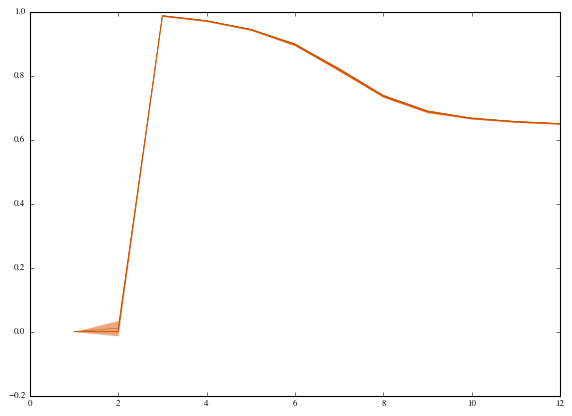

In [760]:
def make121(X):
    return X
    return np.append(np.ones((np.array(X)[:, 2:].shape[0], 2)), np.array(X)[:, 2:], axis=1)
    
plt.figure(None, figsize=(3.42/2.0*5, 1.2*5), frameon=False)
L_max = 12
X = [range(1, L_max+1)]
for T in [12, 14, 16, 18]:
    confidence_intervals(X, make121(globals()["jsT%d" % T]), c="#d35400", label=T, lw=0.5)

confidence_intervals(X, make121(sing), c="#f39c12", label="Single", lw=0.5)
plt.xlim(1, L_max)
plt.ylim(0, 1.1)

plt.legend(loc="lower left", fontsize=10, frameon=False)

#plt.savefig("figures/NMI_vs_L_where_T_equals_is_1_and_3.pdf")
plt.show()